 * Generate dozen datapoints, render pairs of raw pygame images and processed ones
 * Fix robot orientation, angles, rendering
 * Generate 10k and 100k datasets, save as 'random-dataset10k.pickle' and 'random-dataset100k.pickle'

In [1]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os

import matplotlib

In [2]:
# spawn gym environment
#from env import ArmRobotEnv
#env = ArmRobotEnv()
#DATASETDIR = "datasets.arms"

from myenv import MyEnv
env = MyEnv()
DATASETDIR = "datasets.balls"

pygame 2.0.1 (SDL 2.0.14, Python 3.6.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Visualize relationships between actuators and robot poses

In [3]:
N = 3
a_space = np.linspace(-1., 1., N)

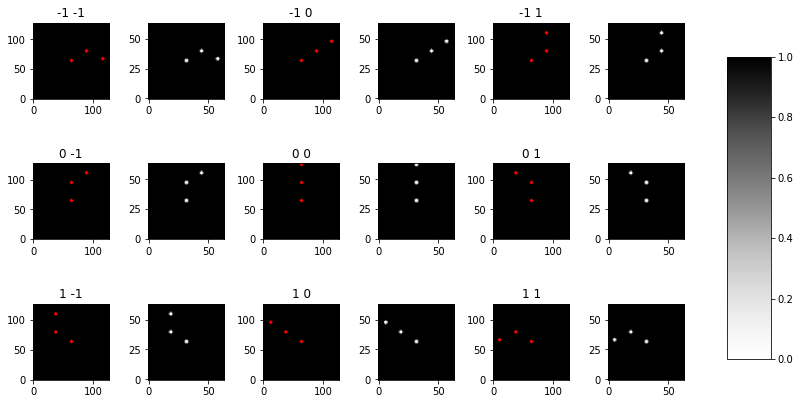

In [8]:
fig, axs = plt.subplots(N, N*2, figsize=(12, 6))
fig.tight_layout()
col_map = plt.get_cmap('Greys')

for i in range(N):
    for j in range(N):
        env.step(np.array([a_space[i], a_space[j]]))
        env.render()        
        raw_img_array = env.get_raw_image()
        img_array = env.get_image()
        
        axs[i][2*j].title.set_text("%d %d" % (a_space[i], a_space[j]))
        axs[i][2*j].imshow(raw_img_array, origin='lower')

        assert((len(img_array.shape) == 3) and img_array.shape[2] == 1) ## (D, D, C=1)
        last_im = axs[i][2*j+1].imshow(img_array[...,0], cmap=col_map, origin='lower')

# https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
_ = fig.colorbar(last_im, cax=cbar_ax)

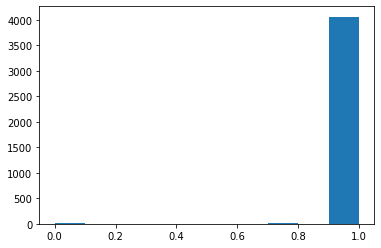

In [9]:
_ = plt.hist(img_array.flatten())

## Generate 100k datapoints for training, 100 for testing and 100 for validation

In [10]:
import time

def gen_data2(actions):
    """
    Gets: an array of actions (actions indexed by first dimension)
    Generates dataset and returns actions and corresponding environment images in a dict
    """
    N = actions.shape[0]
    estimated_time = N * 0.035
    print("Generating %d datapoints ... (approx %f sec)" % (N, estimated_time))

    A, Y = [], []
    
    env.reset()
    start_time = time.time()
    
    for i in range(N):
        action = actions[i]
        obs, _reward, _done, _info = env.step(action)
        env.render()

        y = env.get_image()

        A.append(action.flatten())
        Y.append(y)
  
    elapsed = time.time() - start_time
    print("Generated %d data points. Actual time: %.1fs (%f sec/datapoint)" % (N, elapsed, elapsed/N))

    return {'A': np.array(A), 'Y': np.array(Y)}

### Implementations of save_dataset() and load_dataset()

In [11]:
import pickle

def load_dataset(filename):
    with open(filename, 'rb') as handle:
        return pickle.load(handle)

def save_dataset(dataset, filename):
    # https://betterprogramming.pub/load-fast-load-big-with-compressed-pickles-5f311584507e
    with open(filename, 'wb') as handle:
        pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Dataset saved in %s" % filename)

### Generate and save random datasets

In [12]:
angles = np.random.uniform(low=-1.0, high=1.0, size=(100000,2))
dataset = gen_data2(angles)
save_dataset(dataset, os.path.join(DATASETDIR, 'dataset-random-100k.pickle'))

Generating 100000 datapoints ... (approx 3500.000000 sec)
Generated 100000 data points. Actual time: 113.6s (0.001136 sec/datapoint)
Dataset saved in datasets.balls\dataset-random-100k.pickle


In [13]:
angles = np.random.uniform(low=-1.0, high=1.0, size=(10000, 2))
dataset = gen_data2(angles)
save_dataset(dataset, os.path.join(DATASETDIR, 'dataset-random-10k.pickle'))

Generating 10000 datapoints ... (approx 350.000000 sec)
Generated 10000 data points. Actual time: 11.7s (0.001166 sec/datapoint)
Dataset saved in datasets.balls\dataset-random-10k.pickle


## Visualize

In [14]:
def visualize(data, N=3, M=6):
    """
    Plot NxM array of plots
    """
    
    assert(data['Y'].shape[0] >= N*M)

    fig, axs = plt.subplots(N, M, figsize=(12, 6))
    fig.tight_layout()
    col_map = plt.get_cmap('Greys')

    for i in range(N):
        for j in range(M):
            k = i*N+j
            
            img_array = data['Y'][k]
            assert((len(img_array.shape) == 3) and img_array.shape[2] == 1) ## (D, D, C=1)
            axs[i][j].title.set_text("%.2f %.2f" % (data['A'][k,0], data['A'][k,1]))
            last_im = axs[i][j].imshow(img_array[...,0], cmap=col_map, origin='lower')

    # https://stackoverflow.com/questions/13784201/matplotlib-2-subplots-1-colorbar
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    _ = fig.colorbar(last_im, cax=cbar_ax)

### Load and visualize the dataset

In [15]:
loaded_dataset = load_dataset(os.path.join(DATASETDIR, 'dataset-random-10k.pickle'))

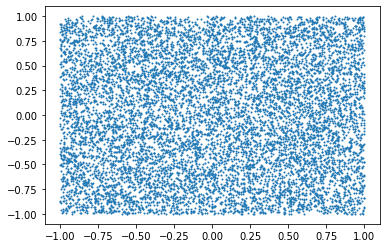

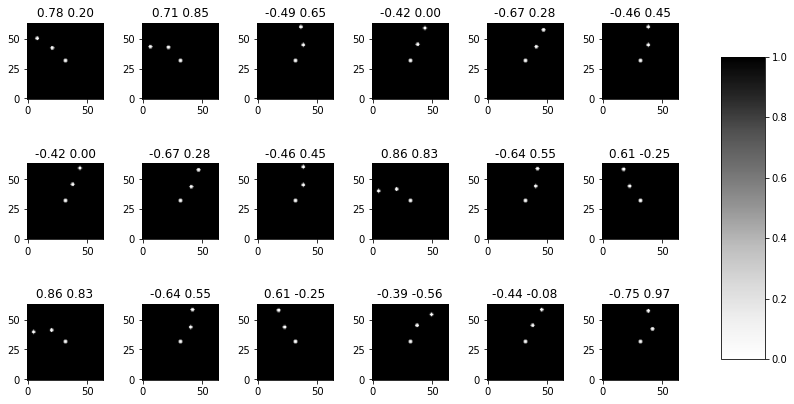

In [16]:
plt.scatter(loaded_dataset['A'][:,0], loaded_dataset['A'][:,1], 1)
visualize(loaded_dataset)